In [54]:
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_ MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

##1) Data Exploration

In [55]:
df = pd.read_csv("international-airline-passengers.csv")
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [56]:
df.columns = ["Month", "Passengers"]
df.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [57]:
df.tail()

,Month,Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [58]:
df.shape

(145, 2)

In [59]:
df.dtypes

Month          object
Passengers    float64
dtype: object

In [60]:
df.isnull().sum()

Month         0
Passengers    1
dtype: int64

In [61]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


##2) Data Preparation

In [62]:
df = df[:144]

In [63]:
df.tail()

,Month,Passengers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       144 non-null    object 
 1   Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [65]:
df["Month"] = pd.to_datetime(df["Month"])

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


In [67]:
print("Minimum Tarih:", df["Month"].min())
print("Maksimum Tarih:", df["Month"].max())

Minimum Tarih: 1949-01-01 00:00:00
Maksimum Tarih: 1960-12-01 00:00:00


In [68]:
df.index = df["Month"]

In [69]:
df.head()

,Month,Passengers
Month,,
1949-01-01,1949-01-01,112.0
1949-02-01,1949-02-01,118.0
1949-03-01,1949-03-01,132.0
1949-04-01,1949-04-01,129.0
1949-05-01,1949-05-01,121.0


In [70]:
df.drop("Month", axis=1, inplace=True)

In [71]:
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [72]:
result_df = df.copy()

<AxesSubplot:title={'center':'Monthly airline passengers'}, xlabel='Month'>

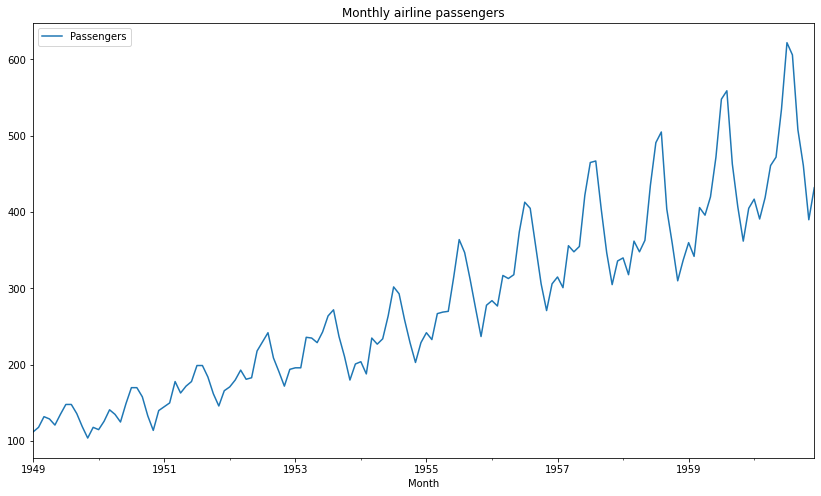

In [73]:
df.plot(figsize=(14, 8), title='Monthly airline passengers')

In [74]:
data = df["Passengers"].values

In [ ]:
data[0:5]

In [76]:
type(data[0:5])

numpy.ndarray

In [77]:
type(data[0])

numpy.float64

In [78]:
data = data.astype('float32')

In [79]:
type(data[0])

numpy.float32

In [80]:
data.shape

(144,)

In [81]:
data = data.reshape(-1,1)

In [82]:
data.shape

(144, 1)

In [83]:
def split_data(dataframe, test_size):
  position = int(round(len(dataframe) * (1-test_size)))
  train = dataframe[:position]
  test = dataframe[position:]
  return train,test,position

In [84]:
train, test, position = split_data(data,0.33)

In [85]:
print(train.shape, test.shape)

(96, 1) (48, 1)


In [86]:
scaler_train = MinMaxScaler(feature_range = (0,1))

In [87]:
train = scaler_train.fit_transform(train)

In [88]:
scaler_test = MinMaxScaler(feature_range = (0,1))

In [89]:
test = scaler_test.fit_transform(test)

In [90]:
train[:5]

array([[0.02588999],
       [0.04530746],
       [0.09061491],
       [0.08090615],
       [0.05501619]], dtype=float32)

In [91]:
test[:5]

array([[0.04361373],
       [0.        ],
       [0.17133951],
       [0.1464175 ],
       [0.16822433]], dtype=float32)

In [93]:
def create_features(data, lookback):
  X, Y = [], []
  for i in range(lookback, len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])
  
  return np.array(X), np.array(Y)

In [94]:
lookback = 1

In [95]:
X_train, y_train = create_features(train, lookback)

In [96]:
X_test, y_test = create_features(test,lookback)

In [97]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(95, 1) (95,) (47, 1) (47,)


In [98]:
X_train = np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test = np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [99]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(95, 1, 1) (95, 1) (47, 1, 1) (47, 1)


##3) Modeling

In [100]:
model = Sequential()

model.add(SimpleRNN(units=50,
                    activation='relu',
                    input_shape=(X_train.shape[1], lookback)))
model.add(Dropout(0.2))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [101]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [103]:
callbacks = [EarlyStopping(monitor='val_loss',patience=3, verbose=1, mode='min'),
             ModelCheckpoint(filepath='mymodel.h5',monitor='val_loss',mode='min',
                             save_best_only=True,save_weights_only=False,verbose=1)]

In [104]:
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=50,
    batch_size=1,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    shuffle=False
)

Epoch 1/50
70/95 [=====================>........] - ETA: 0s - loss: 0.0117
Epoch 1: val_loss improved from inf to 0.03485, saving model to mymodel.h5
95/95 [==============================] - 1s 5ms/step - loss: 0.0152 - val_loss: 0.0348
Epoch 2/50
74/95 [======================>.......] - ETA: 0s - loss: 0.0145
Epoch 2: val_loss improved from 0.03485 to 0.02477, saving model to mymodel.h5
95/95 [==============================] - 0s 2ms/step - loss: 0.0170 - val_loss: 0.0248
Epoch 3/50
77/95 [=======================>......] - ETA: 0s - loss: 0.0096
Epoch 3: val_loss improved from 0.02477 to 0.02089, saving model to mymodel.h5
95/95 [==============================] - 0s 2ms/step - loss: 0.0110 - val_loss: 0.0209
Epoch 4/50
78/95 [=======================>......] - ETA: 0s - loss: 0.0070
Epoch 4: val_loss did not improve from 0.02089
95/95 [==============================] - 0s 2ms/step - loss: 0.0088 - val_loss: 0.0217
Epoch 5/50
72/95 [=====================>........] - ETA: 0s - loss: 0.00

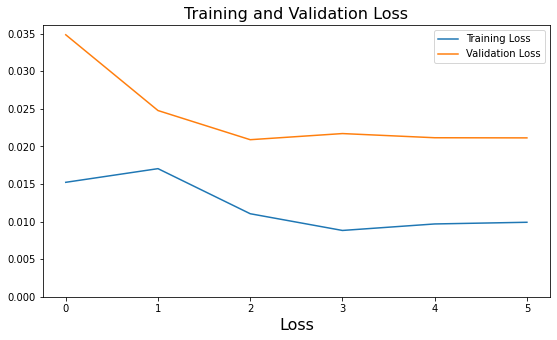

In [105]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch',fontsize=16)
plt.xlabel('Loss',fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)
plt.show()

##4) Evaluation

In [108]:
loss = model.evaluate(X_test,y_test,batch_size=1)
print(f"Loss: {(100.0*loss):.1f}%")

47/47 [==============================] - 0s 1ms/step - loss: 0.0211
Loss: 2.1%


In [109]:
train_predict = model.predict(X_train)

3/3 [==============================] - 0s 4ms/step


In [110]:
test_predict = model.predict(X_test)

2/2 [==============================] - 0s 6ms/step


In [111]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [112]:
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

In [113]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))

In [114]:
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

In [115]:
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 24.614797592163086
Test RMSE: 46.66773986816406


In [116]:
train_prediction_df = result_df[lookback:position]

In [118]:
train_prediction_df["Predicted"] = train_predict

In [120]:
train_prediction_df.head()

,Passengers,Predicted
Month,,
1949-02-01,118.0,134.064087
1949-03-01,132.0,138.679367
1949-04-01,129.0,150.821320
1949-05-01,121.0,148.120667
1949-06-01,135.0,140.987015


In [123]:
test_prediction_df = result_df[position+lookback:]
test_prediction_df["Predicted"] = test_predict
test_prediction_df.head()

,Passengers,Predicted
Month,,
1957-02-01,301.0,336.607941
1957-03-01,356.0,326.491028
1957-04-01,348.0,372.966583
1957-05-01,355.0,365.764862
1957-06-01,422.0,372.066376


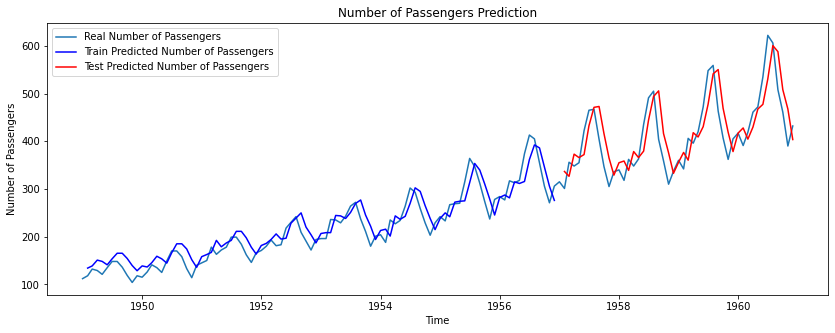

In [124]:
plt.figure(figsize=(14,5))
plt.plot(result_df, label = 'Real Number of Passengers')
plt.plot(train_prediction_df["Predicted"], color='blue', label='Train Predicted Number of Passengers')
plt.plot(test_prediction_df["Predicted"], color='red', label='Test Predicted Number of Passengers')
plt.title('Number of Passengers Prediction')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()